In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import pickle
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import itertools
from tabulate import tabulate
import joblib
from joblib import dump
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [2]:
train=pd.read_csv('./dataset/trainData.txt', sep=',')
test=pd.read_csv('./dataset/testData.txt',sep=',')

In [3]:
train.head(10000000000)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


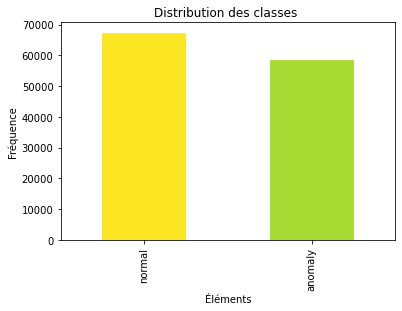

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Supposons que vous avez un DataFrame df avec une colonne 'col' contenant les données
# df = pd.DataFrame({'col': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]})
# Utilisez votre propre DataFrame ou créez-en un pour les besoins de l'exemple.

# Calcul de la fréquence de répétition des éléments
freq = train['class'].value_counts()

# Sélection des 50 premiers éléments avec une grande répétition
top_50_high_freq_elements = freq.head(15)

# Création d'une colormap basée sur les fréquences
colors = plt.cm.viridis(top_50_high_freq_elements / top_50_high_freq_elements.max())

# Tracé de l'histogramme avec des couleurs associées aux fréquences
bars = top_50_high_freq_elements.plot(kind='bar', color=colors)

# Configuration du titre et des étiquettes des axes
plt.title('Distribution des classes ')
plt.xlabel('Éléments')
plt.ylabel('Fréquence')

# Configuration de l'axe y pour n'afficher que les valeurs de fréquence multiples de 2
# plt.yticks(np.arange(0, top_50_high_freq_elements.max() + 1, 50))

# Ajout de la légende de couleurs
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])


# Affichage du graphique
plt.show()


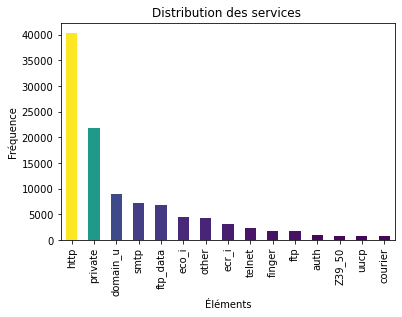

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Supposons que vous avez un DataFrame df avec une colonne 'col' contenant les données
# df = pd.DataFrame({'col': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]})
# Utilisez votre propre DataFrame ou créez-en un pour les besoins de l'exemple.

# Calcul de la fréquence de répétition des éléments
freq = train['service'].value_counts()

# Sélection des 50 premiers éléments avec une grande répétition
top_50_high_freq_elements = freq.head(15)

# Création d'une colormap basée sur les fréquences
colors = plt.cm.viridis(top_50_high_freq_elements / top_50_high_freq_elements.max())

# Tracé de l'histogramme avec des couleurs associées aux fréquences
bars = top_50_high_freq_elements.plot(kind='bar', color=colors)

# Configuration du titre et des étiquettes des axes
plt.title('Distribution des services ')
plt.xlabel('Éléments')
plt.ylabel('Fréquence')

# Configuration de l'axe y pour n'afficher que les valeurs de fréquence multiples de 2
# plt.yticks(np.arange(0, top_50_high_freq_elements.max() + 1, 50))

# Ajout de la légende de couleurs
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])


# Affichage du graphique
plt.show()

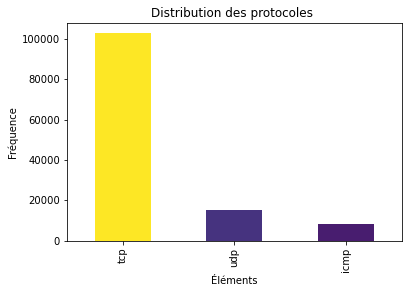

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Supposons que vous avez un DataFrame df avec une colonne 'col' contenant les données
# df = pd.DataFrame({'col': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]})
# Utilisez votre propre DataFrame ou créez-en un pour les besoins de l'exemple.

# Calcul de la fréquence de répétition des éléments
freq = train['protocol_type'].value_counts()

# Sélection des 50 premiers éléments avec une grande répétition
top_50_high_freq_elements = freq.head(15)

# Création d'une colormap basée sur les fréquences
colors = plt.cm.viridis(top_50_high_freq_elements / top_50_high_freq_elements.max())

# Tracé de l'histogramme avec des couleurs associées aux fréquences
bars = top_50_high_freq_elements.plot(kind='bar', color=colors)

# Configuration du titre et des étiquettes des axes
plt.title('Distribution des protocoles ')
plt.xlabel('Éléments')
plt.ylabel('Fréquence')

# Configuration de l'axe y pour n'afficher que les valeurs de fréquence multiples de 2
# plt.yticks(np.arange(0, top_50_high_freq_elements.max() + 1, 50))

# Ajout de la légende de couleurs
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])


# Affichage du graphique
plt.show()

In [7]:
train.describe(include='object')

,protocol_type,service,flag,class
count,125973,125973,125973,125973
unique,3,70,11,2
top,tcp,http,SF,normal
freq,102689,40338,74945,67343


In [8]:
train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [9]:
total=train.shape[0]
missing_columns= [col for col in train.columns if train[col].isnull().sum()>0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per= (null_count/total)*100
    print(f"{col}:{null_count} ({round(per,3)}%)")

In [10]:
train.duplicated()
# print(f"Number of duplicate rows: {train.duplicated().sum()}")

0         False
1         False
2         False
3         False
4         False
          ...  
125968    False
125969    False
125970    False
125971    False
125972    False
Length: 125973, dtype: bool

In [11]:
# sns.countplot(x=train['protocol_type'])

In [12]:
# sns.countplot(x=train['class'])

In [13]:
# sns.countplot(x=test['class'])

In [14]:
# sns.countplot(x=train['service'])

In [15]:
print("Class distribution training set :")
print(train['class'].value_counts())

Class distribution training set :
normal     67343
anomaly    58630
Name: class, dtype: int64


In [16]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [17]:
def le(df):
    for col in df.columns:
        if df[col].dtype=='object':
            label_encoder = LabelEncoder()
            df[col]= label_encoder.fit_transform(df[col])
le(train)
le(test)
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,49,5,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0
125969,8,2,49,9,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,1
125970,0,1,54,9,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,1
125971,0,1,30,5,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0


In [18]:
train.head(1)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,1


In [19]:
train.drop(['num_outbound_cmds'],axis=1,inplace=True)
test.drop(['num_outbound_cmds'],axis=1,inplace=True)

In [20]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [21]:
x_train = train.drop(['class'],axis=1)
y_train =train['class']

In [22]:
service =train['service']
service

0         20
1         44
2         49
3         24
4         24
          ..
125968    49
125969    49
125970    54
125971    30
125972    20
Name: service, Length: 125973, dtype: int32

In [23]:
rfc = RandomForestClassifier()

rfe = RFE(rfc,n_features_to_select=10)
rfe= rfe.fit(x_train,y_train)

feature_map=[(i,v) for i,v in itertools.zip_longest(rfe.get_support(),x_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

# selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [24]:
x_train=x_train[selected_features]
x_train

,protocol_type,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate
0,1,20,9,491,0,2,1.00,0.00,25,0.17
1,2,44,9,146,0,13,0.08,0.15,1,0.00
2,1,49,5,0,0,123,0.05,0.07,26,0.10
3,1,24,9,232,8153,5,1.00,0.00,255,1.00
4,1,24,9,199,420,30,1.00,0.00,255,1.00
...,...,...,...,...,...,...,...,...,...,...
125968,1,49,5,0,0,184,0.14,0.06,25,0.10
125969,2,49,9,105,145,2,1.00,0.00,244,0.96
125970,1,54,9,2231,384,1,1.00,0.00,30,0.12
125971,1,30,5,0,0,144,0.06,0.05,8,0.03


In [25]:
scale= StandardScaler()
x_train=scale.fit_transform(x_train)
test= scale.fit_transform(test)

In [26]:
X_train,X_test,Y_train,Y_test =train_test_split(x_train,y_train,train_size=0.70,random_state=2)

In [27]:
import time
from sklearn.linear_model import LogisticRegression

clfl=LogisticRegression(max_iter=1200000)
start_time=time.time()
clfl.fit(X_train,Y_train.values.ravel())
end_time=time.time()
print("Training time: ",end_time-start_time)

Training time:  0.9647321701049805


In [28]:
start_time=time.time()
Y_test_pred = clfl.predict(X_train)
end_time=time.time()
print("Testing time: ",end_time-start_time)

Testing time:  0.019483089447021484


In [29]:
lg_model= LogisticRegression(random_state=42)
lg_model.fit(X_train,Y_train)

LogisticRegression(random_state=42)

In [30]:
lg_train,lg_test=lg_model.score(X_train,Y_train) , lg_model.score(X_test,Y_test)

print(f"Training score: {lg_train}")
print(f"Test score: {lg_test}")

Training score: 0.9289983102936007
Test score: 0.9273126587637596


In [31]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [32]:
def objective(trial):
    n_neighbors=trial.suggest_int('KNN_n_neighbors',2,16,log=False)
    classifier_obj=KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(X_train,Y_train)
    accuracy=classifier_obj.score(X_test,Y_test)
    return accuracy

In [33]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective,n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9893099068585944], datetime_start=datetime.datetime(2024, 5, 22, 17, 7, 9, 719007), datetime_complete=datetime.datetime(2024, 5, 22, 17, 7, 42, 649779), params={'KNN_n_neighbors': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [66]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(X_train,Y_train)

KNN_train,KNN_test= KNN_model.score(X_train,Y_train),KNN_model.score(X_test,Y_test)

print(f"Training score: {KNN_train}")
print(f"Test score: {KNN_test}")

Training score: 0.9928896247490956
Test score: 0.9893099068585944


In [59]:
# confusion_matrix(X_test,Y_test)
X_train[1]

array([-0.12470616,  1.08730518, -0.73623464, -0.00776224, -0.00491864,
        0.13878877, -1.25318743, -0.0169296 , -0.89115586, -1.00510998])

In [35]:
from sklearn.tree import DecisionTreeClassifier

clfd =DecisionTreeClassifier(criterion='entropy',max_depth=4)
start_time= time.time()
clfd.fit(X_train,Y_train.values.ravel())
end_time=time.time()
print("Training time: ",end_time-start_time)

Training time:  0.33311891555786133


In [36]:
start_time= time.time()
Y_test_pred=clfd.predict(x_train)
end_time=time.time()
print("Testing time: ",end_time-start_time)

Testing time:  0.04913592338562012


In [37]:
def objective(trial):
    dt_max_depth=trial.suggest_int('dt_max_depth',2,32,log=False)
    dt_max_features=trial.suggest_int('dt_max_features',2,10,log=False)
    classifier_obj=DecisionTreeClassifier(max_features=dt_max_features,max_depth=dt_max_depth)
    classifier_obj.fit(X_train,Y_train)
    accuracy=classifier_obj.score(X_test,Y_test)
    return accuracy

In [38]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective,n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.9981212955122777], datetime_start=datetime.datetime(2024, 5, 22, 17, 8, 48, 773230), datetime_complete=datetime.datetime(2024, 5, 22, 17, 8, 49, 222929), params={'dt_max_depth': 27, 'dt_max_features': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=6, value=None)


In [39]:
dt =DecisionTreeClassifier(max_features=study_dt.best_trial.params['dt_max_features'],max_depth=study_dt.best_trial.params['dt_max_depth'])
dt.fit(X_train,Y_train)
# dump(dt,'crssri.joblib')
with open('anomalie.pkl', 'wb') as f:
    # Dump the object 'data' into the file 'f'
    pickle.dump(dt, f)
# pickle.dump(dt,open(','wb'))
dt_train,dt_test = dt.score(X_train,Y_train), dt.score(X_test,Y_test)

print(f"Training score: {dt_train}")
print(f"Test score: {dt_test}")

Training score: 0.9999319581315703
Test score: 0.9979096104995766


In [40]:
X_train

array([[ 2.21931185, -1.17618945,  0.75111129, ..., -0.29422413,
         1.22262133,  1.02185272],
       [-0.12470616,  1.08730518, -0.73623464, ..., -0.0169296 ,
        -0.89115586, -1.00510998],
       [-0.12470616,  1.63788495, -0.73623464, ..., -0.0723885 ,
        -1.03568764, -1.16103019],
       ...,
       [-0.12470616,  0.29202328, -2.22358057, ...,  0.03852931,
        -0.82792321, -0.96056135],
       [ 2.21931185,  1.08730518,  0.75111129, ...,  0.20490602,
        -0.85502292, -0.98283566],
       [ 2.21931185,  0.78142753,  0.75111129, ..., -0.34968303,
        -1.01762117, -1.13875587]])

In [41]:
data =[
    ["KNN",KNN_train,KNN_test],
    ["Logistic Regression", lg_train,lg_test],
    ["Decision Tree",dt_train,dt_test]
]

col_names= ["Model","Train score","Test score"]
print(tabulate(data,headers=col_names,tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train score │   Test score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.99289  │     0.98931  │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.928998 │     0.927313 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999932 │     0.99791  │
╘═════════════════════╧═══════════════╧══════════════╛


In [42]:
# # Chemin du fichier texte
# txt_file_path = './dataset/testData.txt'

# # Fonction pour ouvrir et lire le fichier texte
# def open_txt_file(file_path):
#     with open(file_path, 'r') as txt_file:
#         data = txt_file.read()
#     return data

# # Appel de la fonction pour ouvrir le fichier texte
# txt_data = open_txt_file(txt_file_path)
_data=pd.read_csv('dataset/testData.txt', sep=',')
txt_data = _data.copy()
# test=pd.read_csv('./dataset/testData.txt',sep=',')
# Affichage du contenu du fichier texte
# print(txt_data)
le(txt_data)
label=txt_data['class']

In [43]:
# txt_data.drop(['num_outbound_cmds'],axis=1,inplace=True)
txt_data


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,45,1,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0
1,0,1,45,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0
2,2,1,19,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,1
3,0,0,13,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,0
4,1,1,55,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,1
22540,0,1,22,9,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,1
22541,0,1,22,9,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,0
22542,0,2,11,9,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,1


In [45]:
def confusion_matrix(actual,predicted):
    confusion_matrix = metrics.confusion_matrix(actual,predicted)
    displayconfmax=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=[0,1])
    displayconfmax.plot()
    return plt.show()